### Problem 1

#### (a)

At the first beginning, we need the assumption that $X^TX$ is invertible when $n\geq p$ and $XX^T$ is invertible when $n < p$.

When $n\geq p$, the answer is trivial ans the same as the solution of OLS:
$$
\hat{\beta} = (X^TX)^{-1}X^TY.
$$

When $n < p$, we have 
$$
\hat{\beta} = \arg\min{\|b\|_2} \text{ s.t. } X^TXb = X^TY .
$$

Note that this is a convex problem. We consider the following optimization problem.
$$
\hat{\beta}(\lambda) = \arg\min{\|b\|_2} \text{ s.t. } (X^TX+\lambda I_p)b = X^TY .
$$

By implicit function theorem, one can show that the optimal solution has Lipschitz continuity around $\lambda = 0$. This implies that 
$$
\hat{\beta} = \lim_{\lambda\to 0}\hat{\beta}(\lambda).
$$

On the other hand, $\hat{\beta}(\lambda)$ is actually the solution of ridge regression. One immediately have 
$$
\hat{\beta}(\lambda) = (X^TX + \lambda I_p)^{-1} X^T Y 
$$

Ref. to the following lemma:

*For any $p, n, r>0$, we have $(X^TX + \lambda I_p)^{-1} X^T Y  = X^T(XX^T + \lambda I_n)^{-1} Y $*

So we conclude that $\hat{\beta} = X^T(XX^T)^{-1} Y$

The degrees of freedom can be calculated by $$df = tr(S)$$

When $n\geq p$, $df =$ tr$(X(X^TX)^{-1}X^T)$. If $X^TX$ has full rank, then $df = p$.

When $n< p$, $df =$ tr$(XX^T(XX^T)^{-1})=n$

#### (b)

When $\gamma \leq 1$,

Squared Bias : $0$

Trace Variance : tr($\sigma^2(X^TX)^{-1}$)

When $\gamma > 1$,

Squared Bias : $\|(X^T(XX^T)^{-1}X-I_p)\beta\|^2$

Trace Variance : tr($\sigma^2X^T[(XX^T)^{-1}]^2$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.random import default_rng

In [120]:
p = 500
rng = default_rng(1)
beta = rng.standard_normal(p)/np.sqrt(p)

square_bias = []
variance = []
for n in np.arange(100, 1000, 10):
    X = rng.standard_normal((n, p))
    e = rng.standard_normal(n)
    Y = X.dot(beta) + e
    if n <= p:
        t = (X.T@np.linalg.inv(X@X.T)@X - np.identity(p))@beta
        square_bias.append((t.T@t))
        t = np.linalg.inv(X@X.T)
        variance.append(np.trace(X.T@t@t))
    if n > p:
        square_bias.append(0.0)
        t = np.linalg.inv(X.T@X)
        variance.append(np.trace(t))

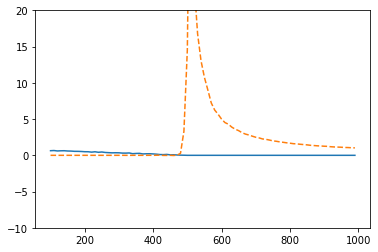

In [124]:
nlist = np.arange(100, 1000, 10)
plt.plot(nlist, square_bias, label='squared bias')
plt.plot(nlist, variance, '--', label='variance')
plt.ylim(-10, 20)
plt.show()

#### (c)

In this question, we need $n \geq p$ otherwise the eigenvalues of $X^TX$ will not be well-defined in $\mathbb{R}$.

The Gradient Descent will converge to the optimal solution given in (a). The code and figure are shown as follow.

In [71]:
class GenData:
    
    def __init__(self, n, p, seed=1):
        rng = default_rng(seed)
        X = rng.standard_normal((n, p))
        b = rng.standard_normal(p)/np.sqrt(p)
        e = rng.standard_normal(n)
        Y0 = X.dot(b)
        Y = Y0 + e 

        lam_max = np.max(np.linalg.eig(X.T@X/n)[0])
        self.X = X
        self.Y = Y
        self.lam = lam_max
        self.b = b
    
    def test(self, n, p, seed=2):
        rng = default_rng(seed)
        X = rng.standard_normal((n, p))
        e = rng.standard_normal(n)
        b = self.b
        Y0 = X.dot(b)
        Y = Y0 + e 
        return X, Y
        

In [47]:
class OptimizeBeta:
    
    def __init__(self, data, lr):
        self.X = data.X
        self.Y = data.Y
        self.lr = lr
        self.__solve__()
        
    def __solve__(self):
        X = self.X
        Y = self.Y
        n, p = X.shape
        if n < p:
            self.betastar = X.T@np.linalg.inv(X@X.T)@Y
        else:
            self.betastar = np.linalg.inv(X.T@X)@X.T@Y
            
    def grad(self, beta):
        X = self.X
        Y = self.Y
        n = self.X.shape[0]
        return 1.0/n* X.T@(Y - X@beta)
    
    def lam(self, l):
        X = self.X
        Y = self.Y
        n, p = X.shape
        I = np.identity(p)
        return np.linalg.inv(X.T@X + n*l*I)@X.T@Y
    
    def time(self, t):
        X = self.X
        Y = self.Y
        n, p = X.shape
        I = np.identity(p)
        return (I - expm(-X.T@X/n*t))@self.betastar

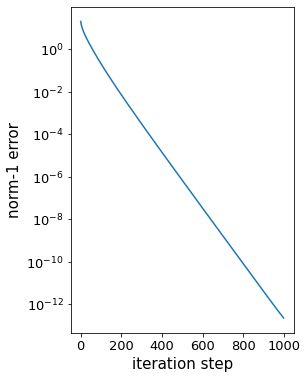

In [11]:
n     = 1000
p     = 500
nrep  = 1000

data  = GenData(n, p)
lr    = 1.0/data.lam
model = OptimizeBeta(data, lr)

betas = np.zeros((nrep, data.X.shape[1]))
beta  = np.zeros(data.X.shape[1])
errors = []

for i in range(1, nrep):
    beta = beta + lr * model.grad(beta)
    errors.append(sum(np.abs(beta - model.betastar)))
fig = plt.figure(figsize=(4,6))
plt.plot(errors)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.yscale('log')
plt.xlabel('iteration step', fontsize=15)
plt.ylabel('norm-1 error', fontsize=15)
plt.show()

#### (d)

https://en.wikipedia.org/wiki/Matrix_differential_equation

Ref. to Matrix Differential Equation, we solve the gradient flow differential equation.
$$
\overset{.}{\beta}(t) = -\frac{X^TX}{n}\beta(t)  + \frac{X^Ty}{n}
$$

$\beta^* = (X^TX)^{-1}X^Ty$
$$
\beta(t) = (I_p - e^{-\frac{X^TX}{n}t})\beta^*
$$

We can further simulate this path and compare it with the figure in (c)

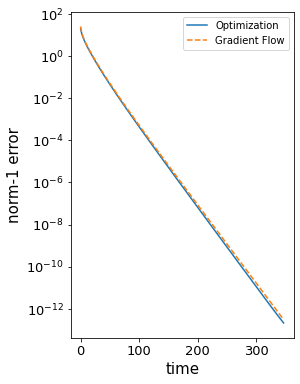

In [41]:
n     = 1000
p     = 500
nrep  = 1000

data  = GenData(n, p)
lr    = 1.0/data.lam
model = OptimizeBeta(data, lr)

betas = np.zeros((nrep, data.X.shape[1]))
beta  = np.zeros(data.X.shape[1])
errors = []

for i in range(nrep):
    beta = beta + lr * model.grad(beta)
    errors.append(sum(np.abs(beta - model.betastar)))

X = data.X
time = lr*nrep
exponent = X.T@X/n
betastar = model.betastar

from scipy.linalg import expm

tlist = np.linspace(0, time, nrep)
path = np.zeros(nrep)
for i in range(nrep):
    t = tlist[i]
    path[i] = np.sum(np.abs(expm(-exponent*t)@betastar))

    
fig = plt.figure(figsize=(4,6))
plt.plot(tlist, errors, label='Optimization')
plt.plot(tlist, path, '--', label='Gradient Flow')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.yscale('log')
plt.xlabel('time', fontsize=15)
plt.ylabel('norm-1 error', fontsize=15)
plt.legend()
plt.show()

#### (e)

By numerical experiment, I find that by taking a relationship between ridge parameter $\lambda$ and time $t$: $\lambda = 1/t$. The solution paths of them can be quite similar. So are the prediction accuracies.

Solution Path:

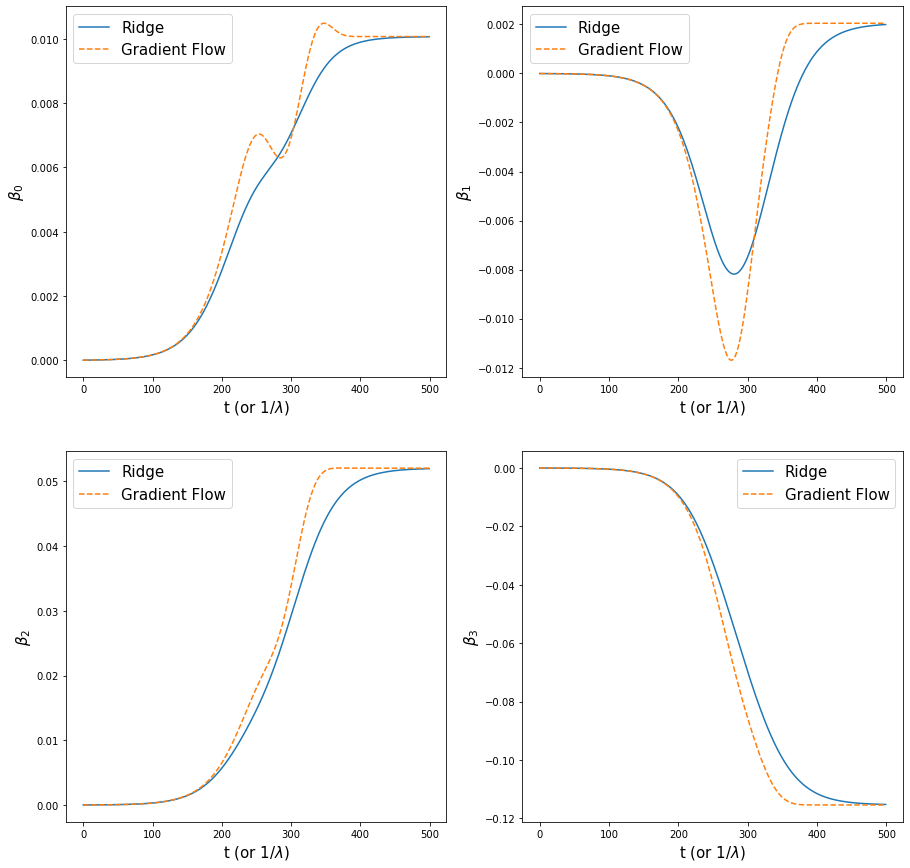

In [94]:
n     = 1000
p     = 500


data  = GenData(n, p)
lr    = 1.0/data.lam
Beta = OptimizeBeta(data, lr)

nlams = 500
lams = np.logspace(-8, 8, nlams, base=np.e)
beta_lams = np.zeros((nlams,p))
for i in range(nlams):
    beta_lams[i,:] = Beta.lam(1.0/lams[i])

ntimes = 500
times = np.logspace(-8, 8, ntimes, base=np.e)
beta_times = np.zeros((ntimes,p))
for i in range(ntimes):
    beta_times[i,:] = Beta.time(times[i])
    
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].plot(beta_lams[:,2*i+j], label='Ridge')
        ax[i,j].plot(beta_times[:,2*i+j], '--', label='Gradient Flow')
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel('t (or 1/$\\lambda$)', fontsize=15)
        ax[i,j].set_ylabel(f'$\\beta_{2*i+j}$', fontsize=15)
plt.show()

Prediction:

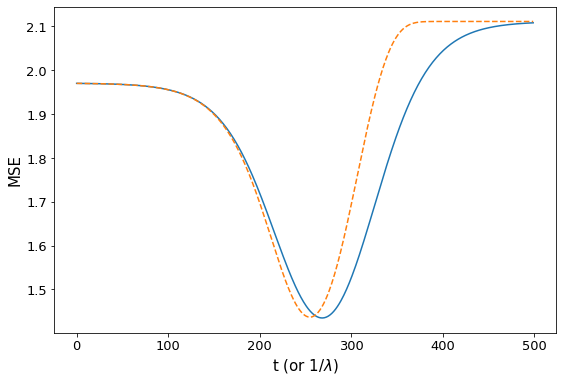

In [86]:
from sklearn.metrics import mean_squared_error as mse
n     = 1000
p     = 500

data  = GenData(n, p)
lr    = 1.0/data.lam
Beta = OptimizeBeta(data, lr)

X_test, Y_test = data.test(n, p)

nlams = 500
lams = np.logspace(-8, 8, nlams, base=np.e)
beta_lams = np.zeros((nlams,p))
for i in range(nlams):
    beta_lams[i,:] = Beta.lam(1.0/lams[i])

ntimes = 500
times = np.logspace(-8, 8, ntimes, base=np.e)
beta_times = np.zeros((ntimes,p))
for i in range(ntimes):
    beta_times[i,:] = Beta.time(times[i])

fig = plt.figure(figsize=(9,6))
mse_ridge = np.zeros(nlams)
mse_gf = np.zeros(ntimes)
for i in range(ntimes):
    mse_ridge[i] = mse(Y_test, X_test@beta_lams[i,:])
    mse_gf[i] = mse(Y_test, X_test@beta_times[i,:])
plt.plot(mse_ridge)
plt.plot(mse_gf, '--')
plt.xlabel('t (or 1/$\\lambda$)', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()